Este notebook versa sobre el dataset de la competición de _**Kaggle**_ **Titanic: Machine Learning from Disaster** (https://www.kaggle.com/c/titanic). A partir de los datos proveidos por **Kaggle** se pretende generar un modelo predictivo que permita predecir con el máximo nível de precisión las instancias del set de test que provee Kaggle. Este proyecto se incluye dentro del curso académico de la asignatura **Tipología y Ciclo de Vida de Datos** del **Máster en Ciencia de Datos** de la **Universitat Oberta de Catalunya**.

En cuanto a los datos. Kaggle pone a disposición de las personas dos dataset:
 1. **training set**: se trata del conjunto de datos donde se entrena el modelo predictivo. Cuenta con 891 instancias y 12 atributos, uno de los cuales es el atributo objetivo.
 2. **test set**: se trata del conjunto de datos cuya clase objetivo pretende predecirse a partir del modelo creado con el conjunto de entrenamiento previo. Cuenta con 418 instancias y no cuenta con el atributo objetivo con el que si cuenta el set de entranamiento.

En cuanto a los atributos presentes en ambos datasets, estos son:
 - **PassengerId**: identificador numérico del pasajero.
 - **Name**: nombre del pasajero.
 - **Pclass**: variable categórica que identifica la clase en la que viajaba el pasajero. Tres posibles valores: 1 (alta) / 2 (media) / 3 (baja)
 - **Sex**: sexo del pasajero. Valores: male/female
 - **Age**: edad del pasajero.
 - **SibSp**: número de hermanos/as y parejas de los pasajeros.
 - **ParCh**: número de niños/as o padres de los pasajeros.
 - **Ticket**: código alfanumérico que identifica el ticket de cada pasajero.
 - **Fare**: cantidad monetaria que cuesta el viaje a cada viajero. No queda clara la divisa. 
 - **Cabin**: código alfanumérico de la cabina en la que realiza el viaje cada pasajero.
 - **Embarked**: código que indica lugar de embarque del pasajero. 3 posibles valores: C (Cherburgo) / S (Southampton) / Q (Queenstown)
 
Por último, el set de entrenamiento cuenta con el atributo **Survived**, atributo categórico binario que indica si la persona a la que hace referencia la instancia sobrevivió o no al hundimiento del Titanic.

# Importación Librerías

A continuación se procede a importar las librerías necesarias para llevar a cabo el objetivo del notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from fancyimpute import KNN
import pandas_profiling
import warnings
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
b='\033[1m'
n='\033[0m'

# Carga Datos

In [3]:
df_train=pd.read_csv("Data_Titanic/train.csv")
df_test=pd.read_csv("Data_Titanic/test.csv")

# Inspección Dataframes

In [4]:
# Calculo dimensiones training set
rowstr=df_train.shape[0]
rowste=df_test.shape[0]
# Calculo dimensiones test set
colstr=df_train.shape[1]
colste=df_test.shape[1]

print(f"{b}Número de Instancias:{n} \n\t{b}- Train:{n} {rowstr} \n\t{b}- Test:{n} {rowste}")
print(f"{b}Número de Columnas:{n} \n\t{b}- Train:{n} {colstr} \n\t{b}- Test:{n} {colste}")

Número de Instancias: 
	- Train: 891 
	- Test: 418
Número de Columnas: 
	- Train: 12 
	- Test: 11


Analizamos la prsencia de **valores ausentes**:

In [5]:
print(f"{b}Valores ausentes df_train{n}:")
print(df_train.isna().sum())
print(f"\n{b}Valores ausentes df_test{n}:")
print(df_test.isna().sum())

Valores ausentes df_train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Valores ausentes df_test:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


A partir de los datos analizados se observa como **df_train** dispone de 3 atributos con valores ausentes:
 - **Age**: 177 registros
 - **Cabin**: 687 registros
 - **Embarked**: 2 registros

Por otro lado, **df_test** dispone de 2 atributos con valores ausentes:
 
 - **Age**: 86 registros
 - **Cabin**: 327 registros

# Preprocesamiento

## Selección Atributos de Interés

A continuación se seleccionan los atributos de interés para lograr desarrollar un modelo predictivo que responda a la pregunta ¿Qué tipo de personas son más proclives a sobrevivir en el hundimiento del Titanic? Cabe destacar que este proceso se lleva a cabo pensando en el set de entrenamiento, con tal de poder aplicar el modelo predictivo que se generará en los siguientes pasos.

Para ello se seleccionan todos los atributos salvo **Name, Ticked,Cabin**. De cara a poder predecir quién sobrevivió al hundimiento, conocer el nombre de los pasajeros es irrelevante, así como la numeración/código del Ticket, dado que disponemos de información más descriptiva como la clase en la que viaja cada individuo, así como los familiares con los que viaje y el precio de billete. Por otro lado, el atributo Cabin también ha sido descartado dado que no ofrece a priori información relevante, mientras que dispone de una alta tasa de valores ausentes, 687 de 891, lo que representa en torno al 77% de los registros.

Por otro lado, al margen de seleccionar atributos también se ha procedido a alterar el orden en el que se almacenan los atributos en el dataframe de manera que estos disponga de un orden más intuitivo.

Así, de cara a tratar los valores ausentes de las variables seleccionadas, solo será necesario realizar este procedemiento con los atributos **Age** y **Embarked**.

In [6]:
train=df_train[['PassengerId','Sex','Age','SibSp','Parch','Embarked','Pclass','Fare','Survived']]
test=df_test[['PassengerId','Sex','Age','SibSp','Parch','Embarked','Pclass','Fare']]

In [7]:
train.head()

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare,Survived
0,1,male,22.0,1,0,S,3,7.2500,0
1,2,female,38.0,1,0,C,1,71.2833,1
2,3,female,26.0,0,0,S,3,7.9250,1
3,4,female,35.0,1,0,S,1,53.1000,1
4,5,male,35.0,0,0,S,3,8.0500,0


In [8]:
test.head()

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare
0,892,male,34.5,0,0,Q,3,7.8292
1,893,female,47.0,1,0,S,3,7.0000
2,894,male,62.0,0,0,Q,2,9.6875
3,895,male,27.0,0,0,S,3,8.6625
4,896,female,22.0,1,1,S,3,12.2875


## Conversión Variables

A continuación se procede a convertir la variable Sex a una variable dicotómica numérica y la variable Embarked a una variable categória con tres factores numéricos enteros. En futuros pasos se procederá a realizar una imputación de valores ausentes a través de k-Nearest Neighbors, algoritmo que utiliza la **distancia euclidea** para identificar los K elementos más semejos a cada registro, razón por la cual es necesario disponer únicamente de atributos numéricos.

Conversión Atributo Sex:

In [9]:
train.Sex=train.Sex.map({'male':0,'female':1})
test.Sex=test.Sex.map({'male':0,'female':1})

Conversión Atributo Embarked:

In [10]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [11]:
train.Embarked=train.Embarked.map({'S':1,'C':2,'Q':3})
test.Embarked=test.Embarked.map({'S':1,'C':2,'Q':3})

Inspección Dataframes:

In [12]:
train.head()

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare,Survived
0,1,0,22.0,1,0,1.0,3,7.2500,0
1,2,1,38.0,1,0,2.0,1,71.2833,1
2,3,1,26.0,0,0,1.0,3,7.9250,1
3,4,1,35.0,1,0,1.0,1,53.1000,1
4,5,0,35.0,0,0,1.0,3,8.0500,0


In [13]:
test.head()

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare
0,892,0,34.5,0,0,3,3,7.8292
1,893,1,47.0,1,0,1,3,7.0000
2,894,0,62.0,0,0,3,2,9.6875
3,895,0,27.0,0,0,1,3,8.6625
4,896,1,22.0,1,1,1,3,12.2875


## Imputación Valores - atributos Age & Embarked

A continuación procederemos a imputar 177 valores del atributo Age y 2 valores del atributo embarked. Dado que el valor que toma la variable Age puede estar relacionado con las variables SibSp,Parch e incluso con el sexo, la clase y el precio del billete se empleará una imputación por K Nearest Neighbors de manera que se imputa en base a K vecinos más próximos. Asimismo los registros a cuyo valor a imputar en la variable Embarked pueden estar relacionados también con la variable Fare y Pclass.

Con tal de aplicar la imputación KNN, emplearemos el método **KNN** de la libreria **fancyimpute**.

In [14]:
# Creamos copia de dataframes
train_imputed = train.iloc[:,1:].copy(deep=True)
test_imputed = test.iloc[:,1:].copy(deep=True)
# Aplicamos imputación KNN
train_imputed.iloc[:,:] = KNN(k=5).fit_transform(train_imputed)
test_imputed.iloc[:,:] = KNN(k=5).fit_transform(test_imputed)

Imputing row 1/891 with 0 missing, elapsed time: 0.243
Imputing row 101/891 with 0 missing, elapsed time: 0.245
Imputing row 201/891 with 0 missing, elapsed time: 0.247
Imputing row 301/891 with 1 missing, elapsed time: 0.249
Imputing row 401/891 with 0 missing, elapsed time: 0.251
Imputing row 501/891 with 0 missing, elapsed time: 0.253
Imputing row 601/891 with 0 missing, elapsed time: 0.255
Imputing row 701/891 with 0 missing, elapsed time: 0.257
Imputing row 801/891 with 0 missing, elapsed time: 0.259
Imputing row 1/418 with 0 missing, elapsed time: 0.044
Imputing row 101/418 with 0 missing, elapsed time: 0.047
Imputing row 201/418 with 1 missing, elapsed time: 0.049
Imputing row 301/418 with 0 missing, elapsed time: 0.051
Imputing row 401/418 with 0 missing, elapsed time: 0.052


Comprobamos la ausencia de valores ausentes:

In [15]:
print(f"{b}Valores ausentes Set Entrenamiento{n}:")
print(train_imputed.isna().sum())
print(f"\n{b}Valores ausentes Set Test{n}:")
print(test_imputed.isna().sum())

Valores ausentes Set Entrenamiento:
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
Pclass      0
Fare        0
Survived    0
dtype: int64

Valores ausentes Set Test:
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
Pclass      0
Fare        0
dtype: int64


La imputación KNN genera numeros reales(float) a la hora de imputar en atributos que son del tipo Entero tal y como puede observarse a continuación:

In [16]:
valEmb=train_imputed['Embarked'].unique()
valAge=train_imputed['Age'].unique()[:10]
print(f'{b}Valores Embarked{n}: {valEmb}')
print(f'{b}Valores Age{n}: \n{valAge}')

Valores Embarked: [1.         2.         3.         1.78054226 1.91085936]
Valores Age: 
[22.         38.         26.         35.         47.80000065 54.
  2.         27.         14.          4.        ]


Con tal de mapear los valores numéricos de Embarked a los valores categóricos y de disponer de valores de Age enteros, redondearemos los valores imputados a estas dos variables a 0 decimales, disponiendo así de variables numéricas enteras.

In [17]:
train_imputed['Embarked']=round(train_imputed['Embarked'],0)
test_imputed['Embarked']=round(test_imputed['Embarked'],0)
train_imputed['Age']=round(train_imputed['Age'],0)
test_imputed['Age']=round(test_imputed['Age'],0)

Volvemos a introducir columna **PassengerId** en ambos Datasets:

In [18]:
train=pd.concat([train['PassengerId'],train_imputed],axis=1)
test=pd.concat([test['PassengerId'],test_imputed],axis=1)

A continuación se procede a transformar las variables del tipo float a integer con tal de que los tipos de datos se asemejen a los del dataframe original:

In [19]:
train=train.astype({'PassengerId':'object',
                    'Sex':'object',
                    'Age':'int64',
                    'SibSp':'int64',
                    'Embarked':'object',
                    'Parch':'int64',
                    'Pclass':'object',
                    'Survived':'object'})
test=test.astype({'PassengerId':'object',
                    'Sex':'int64',
                    'Age':'int64',
                    'SibSp':'int64',
                    'Embarked':'int64',
                    'Parch':'int64',
                    'Pclass':'int64'})

Inspeccionamos dataframes resultantes:

In [20]:
train.head()

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare,Survived
0,1,0,22,1,0,1,3,7.2500,0
1,2,1,38,1,0,2,1,71.2833,1
2,3,1,26,0,0,1,3,7.9250,1
3,4,1,35,1,0,1,1,53.1000,1
4,5,0,35,0,0,1,3,8.0500,0


In [21]:
test.head()

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare
0,892,0,34,0,0,3,3,7.8292
1,893,1,47,1,0,1,3,7.0000
2,894,0,62,0,0,3,2,9.6875
3,895,0,27,0,0,1,3,8.6625
4,896,1,22,1,1,1,3,12.2875


## Análisis Outliers

A continuación procedemos a analizar los valores extremos, mostrando una tabla en la cual se muestran los percentiles 0,25,50,75,85,90,95 y 100 de cada atributo. Al margen de los estadísticos habituales como los valores máximo, mínimo, así como cuartil 1,2 y 3, también se han calculado los percentiles 85,90 y 95 con tal de poder observar con más detalle la evolución de cada atributo en percentiles altos.

,Age,SibSp,Parch,Fare
0.00,0.0,0.0,0.0,0.00000
0.25,21.0,0.0,0.0,7.91040
0.50,29.0,0.0,0.0,14.45420
0.75,38.0,1.0,0.0,31.00000
0.85,45.0,1.0,1.0,56.49580
0.90,48.0,1.0,2.0,77.95830
0.95,55.5,3.0,2.0,112.07915
1.00,80.0,8.0,6.0,512.32920


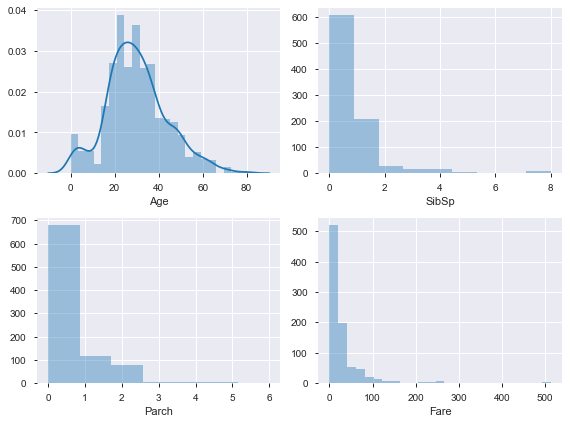

In [22]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
sns.distplot(train['Age'], kde=True, rug=False,ax=ax[0,0])
sns.distplot(train['SibSp'],bins=9, kde=False, rug=False,ax=ax[0,1])
sns.distplot(train['Parch'],bins=7, kde=False, rug=False,ax=ax[1,0])
sns.distplot(train['Fare'], bins=25,kde=False, rug=False,ax=ax[1,1])
plt.tight_layout()
train.quantile([.0,.25,.50,.75,.85,.9,.95,1],axis=0)

A partir de la tabla obtenemos los siguientes insights:
 - **Age**: un 5% de los pasajeros superan los 54 años de edad, con una edad máxima de 80 años. Esta edad, sin embargo, entra dentro de la normalidad, dado que en las fechas del hundimiento del Titanic era posible alcanzar tal edad.
 - **SibSp**: al menos un 50% de los pasajeros no dispone de hermanos/as o pareja en el viaje, mientras que al menos un 90% de los pasajeros solo dispone de uno o ningún familiar de este tipo. El máximo número de familiares de este tipo es de 8, algo que puede entrar dentro de la normalidad, dado que es posible realizar un viaje intercontinental en barco en familia, siendo está muy numerosa. En general se observa como la mayoría de los pasajeros viajan con uno o ningún hermano/a o pareja, mientras que los valores máx extremos corresponden con realidad potencialmente posibles, especialmente teniendo en cuenta las tasas demográficas británicas y francesas de 1912.
 - **ParCh**: al menos el 75% de los pasajeros viaja sin padres ni hijos, mientras que una cantidad menor pero significativa viaja con 1 o 2 parientes de este tipo, mientras que el un número mayor de parientes son residuales, aunque al igual que con la variable SibSp no se corresponde con realidades improcedentes.
 - **Fare**: se observa la concentración de el 95% de los valores en valores menores o iguales a 112,079 unidades momnetarias. Así, existe un 5% de instancias que disponen de valores comprendidos aproximadamente entre 112,0789 y 512,32 unidades monetarios, lo cual supone una dispersión muy elevada. Asimismo, existen pasajeros que de acuerdo con los datos están viajando gratis. Tanto la existencia de valores muy extremos como los valores nulos, pueden deberse a razones como puede ser la clase en la que viajan los pasajeros o que los pasajeros que no paguen billete formen parte de la tripulación. En cualquier caso a continuación se procede a realizar un análisis más pormenorizado de este atributo.

In [23]:
fare0=train[train['Fare']==0.0]
numfare0=fare0.count()[0]
numFare0Clas=fare0['Pclass'].value_counts()

fareCara=train[train['Fare']>112.07915]
numfareCara=fareCara.count()[0]
numFareCaraClas=fareCara['Pclass'].value_counts()

print(f'{b}Pasajeros cuyo precio de billete es 0:{n} {numfare0}')
print(f'Distribución por Clase:\n{numFare0Clas}')
print(f'{b}Número de pasajeros cuyo precio de billete es mayor a 112,08:{n} {numfareCara}')
print(f'Distribución por Clase:\n{numFareCaraClas}')


Pasajeros cuyo precio de billete es 0: 15
Distribución por Clase:
2.0    6
1.0    5
3.0    4
Name: Pclass, dtype: int64
Número de pasajeros cuyo precio de billete es mayor a 112,08: 45
Distribución por Clase:
1.0    45
Name: Pclass, dtype: int64


Tras observar la presecia de 15 instancias con un valor de Fare de 0 y 45 instancias con valores de Fare superiores a 112,08 unidades monetarias, se observa que la clase no tiene nada que ver con no pagar billete, mientras que los billetes claros son exclusivamente de primera clase, lo cual implica que estos valores entran dentro de los esperable y la normalidad de mayores precios para primera clase. Debido a esto se ha optado por no realizar tratamiento alguno en cuanto a valores extremos.

# Análisis de Datos

En el siguiente apartado se procederá a realizar un análisis exploratorio de datos que complemente los descubierto en el análisis de Outliers. Para ello se procederá por generar los estadísticos descriptivos de cada variable, así como representaciones gráficas de cada variable discriminada en función de la variable **Survived**, a través de la cual se pretende generar ciertos conocimiento de cara a realizar Feature Engineering antes de aplicar el modelo predicitivo. Todo este análisis se realizará sobre el **Set de Entrenamiento**. Una vez realizado estos pasos se procederá a la comprobación de normalidad y homogeneidad de la varianza, previo paso a la aplicación de los análisis.

Más adelante se procederá a realizar **pruebas de significación estadística**, tanto para variables numéricas como categóricas, con talde conocer si existen diferencias estadísticas para cada atributo entre aquellos que sobrevivieron y los que murieron en el hundimiento del Titanic. En segundo lugar se procederá a realizar un **ánalisis de correlaciones** generando variables categóricas dummy con tal de analizr todas las variables sin importar el tipo de dato, para por último crear un **modelo predictivo** empleando un modelo Random Forest.

In [24]:
train.describe(include="all")

,PassengerId,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare,Survived
count,891.0,891.0,891.000000,891.000000,891.000000,891.0,891.0,891.000000,891.0
unique,891.0,2.0,NaN,NaN,NaN,3.0,3.0,NaN,2.0
top,891.0,0.0,NaN,NaN,NaN,1.0,3.0,NaN,0.0
freq,1.0,577.0,NaN,NaN,NaN,644.0,491.0,NaN,549.0
mean,NaN,NaN,30.026936,0.523008,0.381594,NaN,NaN,32.204208,NaN
std,NaN,NaN,13.824394,1.102743,0.806057,NaN,NaN,49.693429,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,NaN,NaN,21.000000,0.000000,0.000000,NaN,NaN,7.910400,NaN
50%,NaN,NaN,29.000000,0.000000,0.000000,NaN,NaN,14.454200,NaN
75%,NaN,NaN,38.000000,1.000000,0.000000,NaN,NaN,31.000000,NaN


## Comprobación de la Normalidad y la Homocedasticidad

De cara a proceder a la **comprobación de la normalidad** de los atributos numéricos se aplicará la prueba **Shapiro-Wilk**. Esta prueba compara la distribución de los datos con una distribución normal, asumiendo como hipótesis nula que los datos están distribuidos de manera normal, lo que implica que un p-value inferior a 0.05 lleva a rechazar esta hipótesis nula y por tanto a concluir que los datos no cuenta con una distribución normal. 

In [25]:
varNum=[2,3,4,7]
shapiro=[]
for i in varNum:
    aux=stats.shapiro(train.iloc[:,i])
    shapiro.append([train.columns[i],aux[0],aux[1]])
pd.DataFrame(shapiro,columns=['Variable','Estadístico','p-value'])

,Variable,Estadístico,p-value
0,Age,0.980395,1.431199e-09
1,SibSp,0.512966,5.745324e-44
2,Parch,0.532815,2.382207e-43
3,Fare,0.521891,1.079000e-43


A partir de los p-value obtenidos, todos ellos inferiores a 0.05, se concluye que los atributos **Age,SibSp,Parch,Fare** no cuenta con una distribución normal.

En cuanto a la **homogeneidad de la varianza** o **homocedasticidad**, dado que los atributos numéricos no cuentan con una distribución normal se procederá a aplicar el test **Fligner-Killeen**, prueba no paramétrica que asume como hipótesis nula la igualdad de varianzas entre los datos de diferentes grupos. Así, se procederá a comprobar la homocedasticidad de los atributos numéricos respecto a las diferentes categorías de la variable **Survived**.

In [26]:
varNum=[2,3,4,7]
fligner=[]
for i in varNum:
    varSurv=train[train['Survived']==1][train.columns[i]]
    varDied=train[train['Survived']==0][train.columns[i]]
    aux=stats.fligner(varSurv,varDied)
    fligner.append([train.columns[i],aux[0],aux[1]])
pd.DataFrame(fligner,columns=['Variable','Estadístico','p-value'])

,Variable,Estadístico,p-value
0,Age,2.600648,1.068200e-01
1,SibSp,1.251390,2.632873e-01
2,Parch,11.253329,7.948034e-04
3,Fare,96.252740,1.011152e-22


Los valores de p-value obtenidos de aplicar el test de Fligner-Killeen a los atributos **Age,SibSp,Parch,Fare**, muestran que las variable **Age** y SibSp disponen igualdad de varianzas entre las personas que sobrevivieron y las que no, mientras que **Parch** y **Fare** no.

**A modo de sintesis ninguna variable numérica se distribuye de manera normal, mientras que solo Parch y Fare muestran homocedasticidad.**

## Aplicación Pruebas Estadísticas

### Pruebas de Significación respecto a Distribuciones de Survived

A continuación se pretende aplicar diferentes pruebas que permitan conocer si existen diferencias significativas para diferentes atributos en función de aquellos que sobrevivieron y aquellos que no al hundimiento del Titanic. Así procederemos a aplicar la prueba de **Wilcoxon** a los atributos **Age,SibSp,Parch,Fare** respecto a **Survived**, dado que comparamos los valores de atributos numéricos respecto al valor de la variable **Survived**, los cuales provienen de la misma muestra y por tanto son dependientes. 

Por otro lado, aplicaremos la **prueba de independencia Chi-Cuadrado** a las variables categóricas **Sex,Embarked,Pclass**.

La prueba **Wilcoxon** se trata de una prueba no parámetrica aplicada a muestras dependendientes, que prueba la hipótesis nula de que dos muestras pareadas relacionadas provienen de la misma distribución, lo cual permite dictaminar si existen diferencias estadísticamente significativas entre los diferentes grupos para las variables arriba mencionadas.

In [27]:
varNum=[2,3,4,7]
wilcoxon=[]
for i in varNum:
    aux=stats.wilcoxon(train[train.columns[i]],train['Survived'])
    wilcoxon.append([train.columns[i],aux[0],aux[1]])
dfaux=pd.DataFrame(wilcoxon,columns=['Variable','Estadístico','p-value'])
dfaux['significativa']=np.where(dfaux['p-value']<0.05,"Si","No")
dfaux

,Variable,Estadístico,p-value,significativa
0,Age,3.5,1.179029e-145,Si
1,SibSp,33705.0,1.771060e-01,No
2,Parch,34675.5,3.867671e-01,No
3,Fare,1.0,3.753773e-145,Si


**La prueba Chi-Cuadrado de independencia** se emplea para determinar si existen diferencias estadísticamente significativas entre dos variables categóricas, al analizar si estas variables están realacionadas en una población. Así, el test contrasta la hipótesis nula según la cual dos variables categóricas son independientes en una población, lo que implica que las frecuencias de una variable son similares o identicas en función de los valores de la otra variable.

In [28]:
varCat=[1,5,6]
chi_sq=[]
for i in varCat:
    contingency_table = pd.crosstab(train[train.columns[i]], train['Survived'],  margins = False)
    chi2, p, dof, ex = chi2_contingency(contingency_table, correction=False)
    chi_sq.append([train.columns[i],chi2,p])
dfaux=pd.DataFrame(chi_sq,columns=['Variable','Estadístico','p-value']) 
dfaux['significativa']=np.where(dfaux['p-value']<0.05,"Si","No")
dfaux

,Variable,Estadístico,p-value,significativa
0,Sex,263.050574,3.711748e-59,Si
1,Embarked,28.005089,8.294157e-07,Si
2,Pclass,102.888989,4.549252e-23,Si


A partir de la aplicación de las pruebas **Wilcoxon** y el **test de independencia Chi-Cuadrado** se obtiene que existen diferencias estadísticamente significativas para las variables **Age,Fare,Sex,Embarked y Pclass** entre las personas que sobrevivieron y las que no. Por otro lado, las variables **SibSp** y **Parch** parecen no disponer de diferencias estadísticamente entre los valores de **Survived**, dado que los p-values de la prueba Wilcoxon son de 0,177 y 0,386 respectivamente, por lo que no se puede rechazar la Hipótesis Nula que establece que las muestras pareadas relacionadas provienen de la misma distribución.

### Correlaciones

In [29]:
df_corr=train.drop(['PassengerId'],axis=1)[['Survived','Sex','Age','SibSp','Parch','Fare','Embarked','Pclass']]
df_corr=pd.get_dummies(df_corr, prefix=['Emb', 'Clase'], columns=['Embarked', 'Pclass'])
df_corr.head(5)

,Survived,Sex,Age,SibSp,Parch,Fare,Emb_1.0,Emb_2.0,Emb_3.0,Clase_1.0,Clase_2.0,Clase_3.0
0,0,0,22,1,0,7.2500,1,0,0,0,0,1
1,1,1,38,1,0,71.2833,0,1,0,1,0,0
2,1,1,26,0,0,7.9250,1,0,0,0,0,1
3,1,1,35,1,0,53.1000,1,0,0,1,0,0
4,0,0,35,0,0,8.0500,1,0,0,0,0,1


In [30]:
pd.DataFrame(spearmanr(df_corr.iloc[:,1:],df_corr.iloc[:,0])[0][0],index=df_corr.columns[:])

,0
Survived,1.000000
Sex,-0.144367
Age,0.195204
SibSp,0.254512
Parch,0.259593
Fare,-0.125722
Emb_1.0,0.090223
Emb_2.0,0.074115
Emb_3.0,0.098013
Clase_1.0,0.064746


El **Análsis de Correlaciones** ha sido llevado a cabo a través del coeficiente de correlación de **Spearman** dado que las variables tomadas en cuenta no se distribuyen de manera normal. Cabe destacar que se han incluido las variables categóricas, creando **dummy categories** para aquellas variables multifactoriales. 

A partir de los datos obtenidos se observan los siguientes aspectos:
 - La clase 3 es la que mayor correlación dispone con Survived, lo que sugiere una mayor mortalidad entre los viajeros humildes.
 - SibSp y Parch disponen de cierta importancia en cuanto a correlación, aunque no generen diferencias estadísticas entre grupos según el test de Wilcoxon. Esto puede deberse a que las personas sin familia murieran en mucho mayor proporción.
 - El coeficiete de Age sugiere que a mayor edad mayor opción de sobrevivir.
 - Sex se caracteriza por una mayor correlación entre las mujeres(valor 0) y la supervivencia.
 - La ligera correlación inversa de Fare sugieren que los valores que no hay una relación tan directa entre precio y tasa de supervivencia.
 - Las variables categóricas dummy no muestran correlaciones altas.

### Random Forest Classifier

De cara a aplicar un modelo como **Random Forest Classifier**, procederemos a aplicar la división del conjunto de datos **train** en el conjunto de datos train y test. Cabe destacar que pese a que este dataframe es un dataframe de entrenamiento, esto se debe al hecho de que el objetivo del proyecto sea generar un modelo predictivo que permita predecir con la máxima precisión la clase de las instancias de **test**. Sin embargo, con tal de afinar los parametros del mejor modo posible, se necesitará un conjunto de entrenamiento y otro de testeo.

Previo a la separación de **df_train1** en el conjunto de entrenamiento y testeo, asignamos los atributos a la variable data y la clase a target.

In [31]:
data_train=train.drop(['PassengerId','SibSp','Parch','Survived'],axis=1)
data_test=test.drop(['PassengerId','SibSp','Parch'],axis=1)
target=train[['Survived']]

Generamos conjuntos de entrenamiento y testeo y convertimos a integer todas las variables objetivo:

In [32]:
x_train, x_test, y_train, y_test = train_test_split(data_train, target, test_size=0.20, random_state=42)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
target=target.astype('int')

Estandarizamos los dataframes:

In [33]:
standard_scaler = StandardScaler()
data_train = standard_scaler.fit_transform(data_train)
data_test = standard_scaler.fit_transform(data_test)
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

Aplicamos modelo Random Forest Classifier con un Stratified K Fold Cross Validation, así como un Grid Search que nos permita identificar la mejor combinación de hiperparametros.

In [34]:
# Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)
# Parametros del grid
grid_params={'max_depth':[3,5,8,10,15,25],
            'n_estimators':[10,25,50,100,150],
            'max_features': ['auto'],
            'criterion': ['gini', 'entropy']}
# Objeto grid
clf_rtree = GridSearchCV(RandomForestClassifier(), 
                         grid_params,
                         cv=skf,
                         verbose=1,
                         n_jobs=-1,
                         scoring='accuracy',
                         return_train_score=True)
# Resultado del grid
rtree_results=clf_rtree.fit(data_train, target)
# Resultados
print(b+"Mejor resultado:"+n,rtree_results.best_score_)
print(b+"Mejores parametros:"+n,rtree_results.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.2s finished


Mejor resultado: 0.856341189674523
Mejores parametros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 150}


Comprobamos resultados de los hiperparametros optimos sobre el conjunto de test:

In [35]:
# Creamos modelo a partir de hiperparametros óptimos
model = RandomForestClassifier(criterion=rtree_results.best_params_['criterion'],
                               max_depth=rtree_results.best_params_['max_depth'],
                               max_features=rtree_results.best_params_['max_features'],
                               n_estimators=rtree_results.best_params_['n_estimators'],
                               random_state=0)
# Entrenamiento del modelo
model.fit(data_train, target)
# Generación de predicciones
prediction=model.predict(x_test)
# Calculo de precisión de resultados
accuracy=accuracy_score(y_test, prediction)
# Output
print(f'{b}Precisión del módelo predictivo sobre conjunto de test:{n} {accuracy:.4f}')

Precisión del módelo predictivo sobre conjunto de test: 0.9274


Se puede observar como el modelo generado a partir de los parametros óptimos saliente del Grid Search K-Fold Cross Validation da como mejor resultado una precisión de 0,85; mientras que aplicar eso mismo parametros sobre el conjunto de entrenamiento ofrece una precisión de 0,9106 lo cual mejora los resultados de precisión. Esta configuración de hiperparametros da resultado de precisión suficientemene buenos como para generar las predicciones del conjunto de test.

# Aplicación Modelo Predictivo en Test

In [36]:
# Modelo predictivo
model = RandomForestClassifier(criterion=rtree_results.best_params_['criterion'],
                               max_depth=rtree_results.best_params_['max_depth'],
                               max_features=rtree_results.best_params_['max_features'],
                               n_estimators=rtree_results.best_params_['n_estimators'],
                               random_state=0)
# Entrenamiento
model.fit(data_train, target)
# Generación predicciones
prediction_test=model.predict(data_test)

In [37]:
predicciones=pd.Series(prediction_test).astype(int)
df_pred=pd.concat([df_test,predicciones],axis=1).rename(columns={0:'Survived'})
submission=df_pred[['PassengerId','Survived']]
# Guardado predicciones
submission.to_csv('Titanic_Survived_Predictions.csv',header=True,index = False)
df_pred.to_csv('Df_Titanic_Survived_Predictions.csv',header=True,index = False)

# Representación de Datos: Tablas y Gráficas

A continuación se procederá a mostrar las variables tenidas en cuenta para la construcción del módelo, así como aquellas que han sido descartadas a partir de los resultados de las pruebas de significaión como Wilcoxon. Cabe destacar que para representar la variable Age, esta variable ha sido discretizada de manera que se pueda visualizar de mejor manera este atributo.

In [38]:
train1=train.copy()
bins = pd.IntervalIndex.from_tuples([(-1,6),(6, 11),(11, 16),(16, 21),
                                     (21,26),(26, 31),(31, 36),(36, 41),
                                     (41,46),(46,51),(51,56),(56,61),
                                     (61,66),(66,71),(71,76),(76,81),])
train1['Age2']=pd.cut(train1['Age'], bins)

<Figure size 576x396 with 0 Axes>

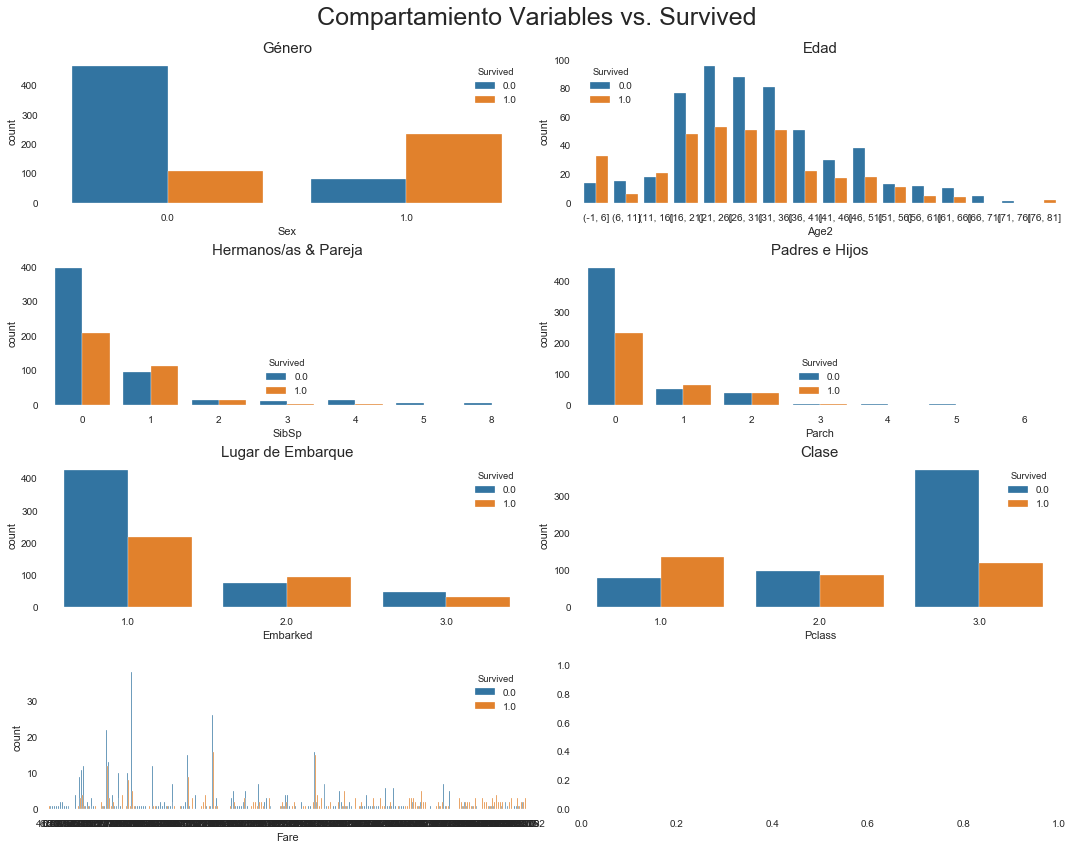

In [39]:
sns.set_style("white")
sns.despine()
fig,ax=plt.subplots(4,2,figsize=(15,12))

sns.countplot(train1['Sex'],hue=train1['Survived'],ax=ax[0,0])
sns.countplot(train1['Age2'],hue=train1['Survived'],ax=ax[0,1])
sns.countplot(train1['SibSp'],hue=train1['Survived'],ax=ax[1,0])
sns.countplot(train1['Parch'],hue=train1['Survived'],ax=ax[1,1])
sns.countplot(train1['Embarked'],hue=train1['Survived'],ax=ax[2,0])
sns.countplot(train1['Pclass'],hue=train1['Survived'],ax=ax[2,1])
sns.countplot(train1['Fare'],hue=train1['Survived'],ax=ax[3,0])


ax[0,0].set_title("Género",fontsize=15)
ax[0,1].set_title("Edad",fontsize=15)
ax[1,0].set_title('Hermanos/as & Pareja',fontsize=15)
ax[1,1].set_title("Padres e Hijos",fontsize=15)
ax[2,0].set_title("Lugar de Embarque",fontsize=15)
ax[2,1].set_title('Clase',fontsize=15)

st=fig.suptitle("Compartamiento Variables vs. Survived",fontsize=25)
plt.tight_layout()

#Fijar lugar de titulo superior
st.set_y(0.98)
fig.subplots_adjust(top=0.92)

A partir de las pruebas de significación hemos observado como todas las variables salvo SibSp y Parch generan diferencias estadísticamente significativas entre las personas que sobrevivieron y murieron en el hundimiento del Titanic. A nivel de atributos específicos se observa lo siguiente:
 - Las mujeres(1.0) sobrevieron en mayor proporción que los hombres(0.0).
 - Los menores de 16 años parecen sobrevivir más,mientras que el resto dispone de mayor proporción de muertos que supervivientes.
 - Las personas que embarcaron en Southampton(1.0) murieron en mayor proporción, al mismo tiempo que fue el origen con mayor número de pasajeros embarcados. Por otro lado, hubo más supervivientes entre los embarcados en Cherburgo(2.0), mientras que el caso de Queenstown(3.0) murieron más personas que sobrevivieron.
 - Las personas de clase 3 murieron en una proporción significativamente mayor, mientras que los de clase 2 mantienen un equilibrio y en la clase 1 sobrevivieron más personas de las que murieron.
 - En cuanto mayor es el precio del billete, aumenta la proporción de supervivientes.

En cuanto a las variables SibSp y Parch, las cuales como hemos mencionados previamente no generan diferencias estadísticamente significativas entre aquellos que sobrevivieron y aquellos que no, según el test de Wilcoxon observamos:

 - Aquellas personas si parientes de un tipo u otro murieron en mucha mayor proporción, mientras que aquellas con algún tipo de familiar sobrevivieron en la misma proporción a morir. Solo disponer de diferencias significativas en uno de los valores(0) puede ser la razón para no poder rechazar la hipótesis nula del test de wilcoxon.

# Conclusiones

A modo de conclusión, cabe destacar que hemos partido de la selección de atributos con mayor potencial para generar un modelo predictivo, para a continuación realizar la imputación de valores ausentes a través del método k-Nearest Neighbors y realizar un análisis de los valores extremos. 

Una vez en disposición de un dataframe preprocesado se ha procedido a comprobar la normalidad y homocedasticidad de los atributos para a continuación aplicar pruebas de significación estadística, Wilcoxon en caso de las numéricas y el tes Chi-Cuadrado de independencia en el caso de las variables categóricas. También se ha realizado un análisis de correlaciones, generando categorías dummy para poder incluir las variables categóricas; y  así por último desarrollar un modelo predictivo utilizando un clasificador Random Forest.

A partir de los test de significación se ha podido identificar las variables a tomar en cuentas para la creación del modelo predictivo, mientras que el análisis de correlaciones nos ha permitido conocer la influencia de cada variable y la dirección respeto a la supervivencia o no de los pasajeros.

Por último se ha realizado visualizaciones de las variables tomadas en cuenta para la generación del modelo predictivo,así como aquellas descartadas con tal de observar las diferencias entre aquellas personas que sobrevivieron y no al hundimiento.

A modo de resumen, tras haber completado todo este proceso y viendo los resultado de precisión obtenidos con el conjunto test del dataframe **train**, el cual ha alcanzado 0.9274, frente al 0.856 del Grid Search Cross Validation, podemos concluir que se ha generado un modelo con una capacidad predictiva significativa que permite cumplir con el objetivo establecido al principio del proyecto.